Consideraciones iníciales:

Infelizmente no consigo escribir correctamente en español. Así que proseguiré con el desafío, escribiendo lo en Inglés.

# Data Scientist Challenge

### Problem

The problem consists of predicting the delay probability of flights landing or taking off from Santiago de Chile (SCL). For this purpose, we provide a dataset using public and real data where each row corresponds to a flight that landed or took off from SCL. For each flight the following information is available:

- **Fecha-I** : Scheduled date and time of the flight.
- **Vlo-I** : Programmed flight number.
- **Ori-I** : Programmed origin city code.
- **Des-I** : Programmed destination city code.
- **Emp-I** : Programmed flight airline code.
- **Fecha-O** : Date and time of flight operation.
- **Vlo-O** : Flight operation flight number.
- **Ori-O** : Operation origin city code.
- **Des-O** : Operation destination city code.
- **Emp-O** : Operation flight airline code.
- **DIA** : Operation day of the month of the flight.
- **MES** : Flight operation month number.
- **AÑO** : Year of flight operation.
- **DIANOM** : Day of week of flight operation.
- **TIPOVUELO** : Flight type, I = International, N = National.
- **OPERA** : Operation airline name.
- **SIGLAORI** : Origin city name.
- **SIGLADES** : Destination city name.


### Challenge

1. How is the data distributed? What catches your attention or what is your conclusion about this?

2. Create the following additional columns then export them in a file `synthetic_features.csv`
    - **temporada_alta** : `1` if *Fecha-I* is between December 15th and March 3rd, or July 15th and July 31th, or September 11th and September 30, `0` otherwise
    - **dif_min** : time difference in minutes between *Fecha-O* and *Fecha-I*
    - **atraso_15** : `1` if *dif_min* > 15, `0` otherwise
    - **periodo_dia** : `mañana` (between 5:00 and 11:59), `tarde` (between 12:00 and 18:59) and `noche` (between 19:00 and 4:59), based on *Fecha-I*

3. How is delay rate composed by destination, airline, month, day of week, season (*temporada_alta*) and flight type? What features would you expect to better predict delay?

4. Train one or more models (using algorithms of your choice) to estimate the probability of flight delay. Feel free to create additional variables and/or add external variables.

5. Evaluate your model. How did it perform? Which metrics did you use to evaluate it and why? Why did you choose this algorithm in particular? Which features are more important to the prediction? How would you enhance the model performance?


### Assumptions

- We don't know how this model would be implemented in production. Would it run for each flight right before boarding? Or would it be implemented in order to run daily to all scheduled flights? Or would it run daily predicting delay in all flights scheduled for the next day (or week)? Despite when the model would run, would all operations variables (except `Flecha-O`) be available to the model (`Vlo-O`, `Ori-O`, `Des-O`, `Emp-O`)? We assume that those variables would be available, and we will create some boolean features that checks for inconsistency between scheduled and operation information.


### Further discussions

- We think that weather would be an important flight characteristic to predict delay. So, in production, collecting weather forecast could be a game changing in predicting delay.

- We also think that a flight leaving a certain gate would be influenced by delays in previous flights from the same gate. So this information should be also collected if the model reach production status.

In [174]:
import pandas as pd
from datetime import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


In [175]:
def translating_data(df):

    days_of_week = {
        'Lunes' : 'Monday',
        'Martes' : 'Tuesday',
        'Miercoles' : 'Wednesday',
        'Jueves' : 'Thursday',
        'Viernes' : 'Friday',
        'Sabado' : 'Saturday',
        'Domingo' : 'Sunday'
    }

    columns = [
        'datetime_i', 'flight_number_i', 'origin_code_i', 'destination_code_i', 'airline_code_i',
        'datetime_o', 'flight_number_o', 'origin_code_o', 'destination_code_o', 'airline_code_o',
        'day', 'month', 'year', 'week_day', 'flight_type', 'airline', 'origin', 'destination'
    ]

    df.columns = columns
    df.loc[:, 'week_day'] = df.loc[:, 'week_day'].apply(lambda x: days_of_week[x])

    return df

In [176]:
def get_treated_data():

    flight_data = pd.read_csv('data/dataset_SCL.csv', parse_dates=[0, 5], low_memory=False)
    flight_data = translating_data(flight_data)

    # We encountered a missing value in flight_number_i and, a non numerical value '989P' and flight_number_o treated as a float in the CSV file
    flight_data = flight_data.dropna()
    flight_data['flight_number_i'] = flight_data['flight_number_i'].astype(str)
    flight_data['flight_number_o'] = flight_data['flight_number_o'].apply(lambda x: str(x).replace('.0', ''))

    # It's necessary to create an index that is unique to identify each flight correctly
    flight_data['index'] = flight_data['datetime_o'].astype(str) + '_' + flight_data['flight_number_o'] + '_' +\
        flight_data['origin_code_o'] + '_' + flight_data['destination_code_o'] + '_' + flight_data['airline_code_o']
    flight_data = flight_data.set_index('index')

    return flight_data

In [177]:
def creating_synthetic_features(df):

    synth_df = df.copy()

    # Separating date and time
    synth_df['date_i'] = synth_df['datetime_i'].apply(lambda x: str(x.date()))
    synth_df['time_i'] = synth_df['datetime_i'].apply(lambda x: str(x.time()))

    synth_df['temporada_alta'] = synth_df['date_i'].apply(lambda x: 1 if x[5:] <= '03-03' or (x[5:] >= '07-15' and x[5:] <= '07-31') \
        or (x[5:] >= '09-11' and x[5:] <= '09-30') or x[5:] >= '12-15' else 0)

    synth_df['dif_min'] = synth_df['datetime_o'] - synth_df['datetime_i']
    synth_df.loc[:, 'dif_min'] = synth_df['dif_min'].apply(lambda x: x.total_seconds()/60).astype(int)

    synth_df['atraso_15'] = synth_df['dif_min'] > 15
    synth_df['atraso_15'] = synth_df['atraso_15'].astype(int)

    synth_df['periodo_dia'] = synth_df['time_i'].apply(lambda x: 'mañana' if x >= '05:00:00' and x < '12:00:00' \
        else 'tarde' if x >= '12:00:00' and x < '19:00:00' else 'noche')

    return synth_df[['temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia']]

In [178]:
def saving_synthetic_features(synth_df):

    synth_df.to_csv('data/synthetic_features.csv')

In [179]:
df = get_treated_data()
synth_df = creating_synthetic_features(df)
saving_synthetic_features(synth_df)

df = df.merge(right=synth_df, left_index=True, right_index=True)
df.head()

,datetime_i,flight_number_i,origin_code_i,destination_code_i,airline_code_i,datetime_o,flight_number_o,origin_code_o,destination_code_o,airline_code_o,...,year,week_day,flight_type,airline,origin,destination,temporada_alta,dif_min,atraso_15,periodo_dia
index,,,,,,,,,,,,,,,,,,,,,
2017-01-01 23:33:00_226_SCEL_KMIA_AAL,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Sunday,I,American Airlines,Santiago,Miami,1,3,0,noche
2017-01-02 23:39:00_226_SCEL_KMIA_AAL,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Monday,I,American Airlines,Santiago,Miami,1,9,0,noche
2017-01-03 23:39:00_226_SCEL_KMIA_AAL,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Tuesday,I,American Airlines,Santiago,Miami,1,9,0,noche
2017-01-04 23:33:00_226_SCEL_KMIA_AAL,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Wednesday,I,American Airlines,Santiago,Miami,1,3,0,noche
2017-01-05 23:28:00_226_SCEL_KMIA_AAL,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Thursday,I,American Airlines,Santiago,Miami,1,-2,0,noche


### Analysing the data

1. How is the data distributed? What catches your attention or what is your conclusion about this?

We will proceed with the data analysis using synthetic features too, in order to get more information about the dataset.

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68205 entries, 2017-01-01 23:33:00_226_SCEL_KMIA_AAL to 2017-12-31 15:04:00_400_SCEL_SPJC_JAT
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime_i          68205 non-null  datetime64[ns]
 1   flight_number_i     68205 non-null  object        
 2   origin_code_i       68205 non-null  object        
 3   destination_code_i  68205 non-null  object        
 4   airline_code_i      68205 non-null  object        
 5   datetime_o          68205 non-null  datetime64[ns]
 6   flight_number_o     68205 non-null  object        
 7   origin_code_o       68205 non-null  object        
 8   destination_code_o  68205 non-null  object        
 9   airline_code_o      68205 non-null  object        
 10  day                 68205 non-null  int64         
 11  month               68205 non-null  int64         
 12  year                68205 non-null  int

We saw 3 "errors" while working with the dataset: one missing value and one non numerical record in `flight_number_i`, and a bunch of `flight_number_o` treated as float (example `400.0`) and this is present in the original file (CSV). We dropped the missing data, treated the floating format and we kept the non numerical record in `flight_number_i`.

We will proceed with the analysis with the assumption that all the data is good, with no need to worry about the veracity of the information.

In [181]:
df[['flight_number_i', 'origin_code_i', 'destination_code_i', 'airline']].value_counts()

flight_number_i  origin_code_i  destination_code_i  airline                 
7                SCEL           SCCI                Sky Airline                 365
285              SCEL           SCTE                Grupo LATAM                 364
190              SCEL           SCAR                Sky Airline                 364
273              SCEL           SCTE                Grupo LATAM                 364
802              SCEL           SPJC                Sky Airline                 364
                                                                               ... 
503              SCEL           LEMD                Plus Ultra Lineas Aereas      1
51               SCEL           SCQP                Grupo LATAM                   1
1186             SCEL           SCAR                Grupo LATAM                   1
1178             SCEL           SCAR                Grupo LATAM                   1
9956             SCEL           SPJC                Grupo LATAM                   1

<AxesSubplot:>

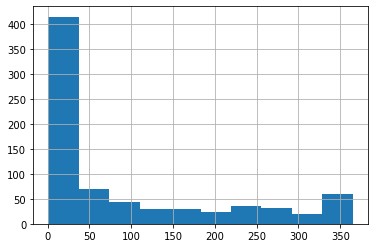

In [182]:
df[['flight_number_i', 'origin_code_i', 'destination_code_i', 'airline']].value_counts().hist()

Most of the flights are not so frequently. For example, the flight LATAM 9956 from SCEL to SPJC only occurs once in the dataset, while the flight Sky Airline 7 from SCEL to SCCI occurs 365 times in the dataset. Maybe the frequency of the flight might be correlated with delay, but we'll check it later.

In [183]:
(df['flight_number_i'] == df['flight_number_o']).value_counts(normalize=True)

True     0.998255
False    0.001745
dtype: float64

Another unexpected finding is that there are some flights with operationing flight number that is different than the schedulled (or programmed) flight number. However, it is a very small fraction (0.1% of all flights), and should not be important to predict fligth delay.

In [184]:
(df['destination_code_i'] == df['destination_code_o']).value_counts()

True     68177
False       28
dtype: int64

Another very unexpected finding is that there are 28 flights whose destination city code is different than the programmed one. This also may be correlated to flight delay, but as it's a very rare behavior, it should not be a strong feature to predict flight delay.

In [185]:
(df['airline_code_i'] == df['airline_code_o']).value_counts(normalize=True)

True     0.726296
False    0.273704
dtype: float64

Yet another unexpected finding is that 27% of the flights are operated by a different airline than scheduled. We'll find later if this behavior is correlated to flight delay.

In [186]:
df['airline'].value_counts(normalize=True)

Grupo LATAM                 0.599545
Sky Airline                 0.209633
Aerolineas Argentinas       0.028576
Copa Air                    0.027124
Latin American Wings        0.024529
Avianca                     0.016890
JetSmart SPA                0.016055
Gol Trans                   0.011817
American Airlines           0.011099
Air Canada                  0.008284
Iberia                      0.005308
Delta Air                   0.005249
Air France                  0.005249
Aeromexico                  0.005146
United Airlines             0.004912
Oceanair Linhas Aereas      0.004091
Alitalia                    0.003797
K.L.M.                      0.003680
British Airways             0.003006
Qantas Airways              0.002859
Lacsa                       0.001349
Austral                     0.001085
Plus Ultra Lineas Aereas    0.000718
Name: airline, dtype: float64

The vast majority of the flights are operated by south american airlines, and LATAM alone sums up to almost 60% of the flights.

In [187]:
df['periodo_dia'].value_counts()

tarde     25506
mañana    25351
noche     17348
Name: periodo_dia, dtype: int64

As expected, there are less flights taking off at night

In [188]:
df['month'].value_counts(normalize=True)

12    0.093190
1     0.089539
11    0.089143
10    0.088439
7     0.087853
8     0.084217
9     0.082252
2     0.081534
3     0.080375
5     0.076827
4     0.073602
6     0.073030
Name: month, dtype: float64

An interesting finding is that October and November have more flights in operation than February, July and September, opposed to what `temporada_alta` suggests.

In [189]:
df['week_day'].value_counts(normalize=True)

Friday       0.150898
Thursday     0.150282
Monday       0.148537
Sunday       0.143626
Wednesday    0.142541
Tuesday      0.141661
Saturday     0.122454
Name: week_day, dtype: float64

There is no significant difference between days of week when comparing number of flights, except Saturday that is 15% smaller than average, but there is no reason so far to expect that this behavior is correlated to flight delay.

### Analysing the data

2. Create additional columns and export them in `synthetic_features.csv`

Already done in `creating_synthetic_features` and `saving_synthetic_features` functions. This file is in the folder `data`.

### Analysing the data

3. How is delay rate composed by destination, airline, month, day of week, season (*temporada_alta*) and flight type? What features would you expect to better predict delay?


#### Destination

In [190]:
aux_df = pd.DataFrame(index=df['destination_code_i'].unique(), columns=['flight_frequency', 'delay_number', 'delay_rate'])
aux_df['flight_frequency'] = df[['destination_code_i', 'atraso_15']].groupby('destination_code_i').count()
aux_df['delay_number'] = df[['destination_code_i', 'atraso_15']].groupby('destination_code_i').sum()
aux_df['delay_rate'] =  100 * (aux_df['delay_number'] / aux_df['flight_frequency'])
aux_df = aux_df.sort_values(by='delay_rate', ascending=False)
aux_df = aux_df.loc[aux_df['flight_frequency'] > 30, :]
aux_df.head(10)

,flight_frequency,delay_number,delay_rate
YSSY,195,113,57.948718
YMML,38,21,55.263158
SAAR,136,54,39.705882
NZAA,361,135,37.396122
MDPC,54,18,33.333333
CYYZ,283,89,31.448763
SACO,1023,308,30.107527
SGAS,232,66,28.448276
SBGL,1434,405,28.242678
SAME,1625,443,27.261538


In [191]:
aux_df.tail(10)

,flight_frequency,delay_number,delay_rate
LIRF,259,29,11.196911
SAZN,37,4,10.810811
MMMX,700,66,9.428571
SCNT,79,7,8.860759
LFPG,359,31,8.635097
SCPQ,235,18,7.659574
KDFW,357,25,7.002801
MPTO,1850,116,6.270270
KATL,358,21,5.865922
KIAH,335,17,5.074627


In [192]:
100*(1 - aux_df['flight_frequency'].sum()/len(df))

0.035188036067734796

<AxesSubplot:>

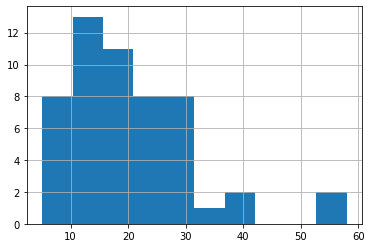

In [193]:
aux_df['delay_rate'].hist()

In [194]:
100 * (1 - aux_df[aux_df['flight_frequency'] > 200]['flight_frequency'].sum()/len(df))

1.7154167583021795

We're using `destination_code_i` because there are only 28 flights in which `destination_code_o` is different than `destination_code_i`, so the analysis and it's conclusion should be the same despite the destination code used.

In order to better understand delay behavior by destination, we ignored all destination cities that receives less than 30 flights. It does not compromise the analysis as it represents only 0.035% of all flight records.

We see that there are cities with almost 60% of flight delay rate. It may be an outlier, as those cities have less than 200 flight records and all cities that receives less than 200 flights sums up to only 1.7% of all flights.

It is clear that most of the destination cities have a delay rate between 10% and 20%, with some cities that do have more than 30%.

#### Airline

In [195]:
aux_df = pd.DataFrame(index=df['airline_code_i'].unique(), columns=['flight_frequency', 'delay_number', 'delay_rate'])
aux_df['flight_frequency'] = df[['airline_code_i', 'atraso_15']].groupby('airline_code_i').count()
aux_df['delay_number'] = df[['airline_code_i', 'atraso_15']].groupby('airline_code_i').sum()
aux_df['delay_rate'] =  100 * (aux_df['delay_number'] / aux_df['flight_frequency'])
aux_df = aux_df.sort_values(by='delay_rate', ascending=False)
aux_df = aux_df.loc[aux_df['flight_frequency'] > 30, :]
aux_df

,flight_frequency,delay_number,delay_rate
PUE,49,30,61.224490
QFU,195,113,57.948718
ACA,565,258,45.663717
LAW,1573,642,40.813732
JMR,100,39,39.000000
GLO,806,287,35.607940
LAP,216,61,28.240741
AVA,1152,306,26.562500
TAM,3049,780,25.582158
ARG,1949,468,24.012314


<AxesSubplot:>

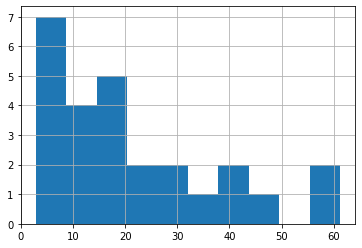

In [196]:
aux_df['delay_rate'].hist()

Like the previous feature analysed, `airline` also have some groups with almost 60% delay rate. However, delay rate density is greater bellow 10% this time.

#### Month

In [197]:
aux_df = pd.DataFrame(index=df['month'].unique(), columns=['flight_frequency', 'delay_number', 'delay_rate'])
aux_df['flight_frequency'] = df[['month', 'atraso_15']].groupby('month').count()
aux_df['delay_number'] = df[['month', 'atraso_15']].groupby('month').sum()
aux_df['delay_rate'] =  100 * (aux_df['delay_number'] / aux_df['flight_frequency'])
aux_df = aux_df.sort_values(by='delay_rate', ascending=False)
aux_df = aux_df.loc[aux_df['flight_frequency'] > 30, :]
aux_df

,flight_frequency,delay_number,delay_rate
7,5992,1758,29.339119
12,6356,1615,25.409062
10,6032,1363,22.596154
11,6080,1199,19.720395
8,5744,996,17.339833
9,5610,967,17.237077
6,4981,852,17.104999
1,6107,978,16.014410
5,5240,827,15.782443
2,5561,843,15.159144


As we saw previously, there are some significant difference between flight number over the months. However, delay rate is quite sensitive to the months, being almost 3 times higher in July than in March. It is interesting to see that July is only the 5th month in flight number, but is the 1st in delay rate, being far away (almost 20% higher than the second month). It is notorious the correlation between flight number and delay rate, as 4 of the 5 months with the most flights are in the top 5 months in delay rate.

#### Season (or `temporada_alta`)

In [198]:
aux_df = pd.DataFrame(index=df['temporada_alta'].unique(), columns=['flight_frequency', 'delay_number', 'delay_rate'])
aux_df['flight_frequency'] = df[['temporada_alta', 'atraso_15']].groupby('temporada_alta').count()
aux_df['delay_number'] = df[['temporada_alta', 'atraso_15']].groupby('temporada_alta').sum()
aux_df['delay_rate'] =  100 * (aux_df['delay_number'] / aux_df['flight_frequency'])
aux_df = aux_df.sort_values(by='delay_rate', ascending=False)
aux_df = aux_df.loc[aux_df['flight_frequency'] > 30, :]
aux_df

,flight_frequency,delay_number,delay_rate
1,22761,4470,19.638856
0,45444,8144,17.920958


Unlike what we thought, delay rate is not so different between `temporada alta` and `temporada baixa`. Delay rate is only 2% higher in absolute values (only 9% in relative values)

#### Flight type

In [199]:
aux_df = pd.DataFrame(index=df['flight_type'].unique(), columns=['flight_frequency', 'delay_number', 'delay_rate'])
aux_df['flight_frequency'] = df[['flight_type', 'atraso_15']].groupby('flight_type').count()
aux_df['delay_number'] = df[['flight_type', 'atraso_15']].groupby('flight_type').sum()
aux_df['delay_rate'] =  100 * (aux_df['delay_number'] / aux_df['flight_frequency'])
aux_df = aux_df.sort_values(by='delay_rate', ascending=False)
aux_df = aux_df.loc[aux_df['flight_frequency'] > 30, :]
aux_df

,flight_frequency,delay_number,delay_rate
I,31239,7048,22.561542
N,36966,5566,15.057079


But, speaking of delay rate in relation to flight type, `international` flights are quite more suusceptible to be delayed than `national` flights. The difference is 7.5% in absolute values, about 50% in relative values.

## More feature validation

- flight frequency (flight number, destination and airline)

In [200]:
df['flight_info'] = df['flight_number_i'] + df['destination_code_i'] + df['airline_code_i']
aux_df = pd.DataFrame(index=df['flight_info'].unique(), columns=['flight_frequency', 'delay_number', 'delay_rate'])
aux_df['flight_frequency'] = df[['flight_info', 'atraso_15']].groupby('flight_info').count()
aux_df['delay_number'] = df[['flight_info', 'atraso_15']].groupby('flight_info').sum()
aux_df['delay_rate'] =  100 * (aux_df['delay_number'] / aux_df['flight_frequency'])
aux_df = aux_df.sort_values(by='flight_frequency', ascending=False)
aux_df = aux_df.loc[aux_df['flight_frequency'] > 30, :]
aux_df

,flight_frequency,delay_number,delay_rate
7SCCISKU,365,51,13.972603
190SCARSKU,364,18,4.945055
273SCTELAN,364,49,13.461538
285SCTELAN,364,42,11.538462
802SPJCSKU,364,38,10.439560
...,...,...,...
50SCFALAW,32,12,37.500000
57SCTELAN,32,10,31.250000
455SAEZLAN,32,16,50.000000
9659SBGRTAM,31,21,67.741935


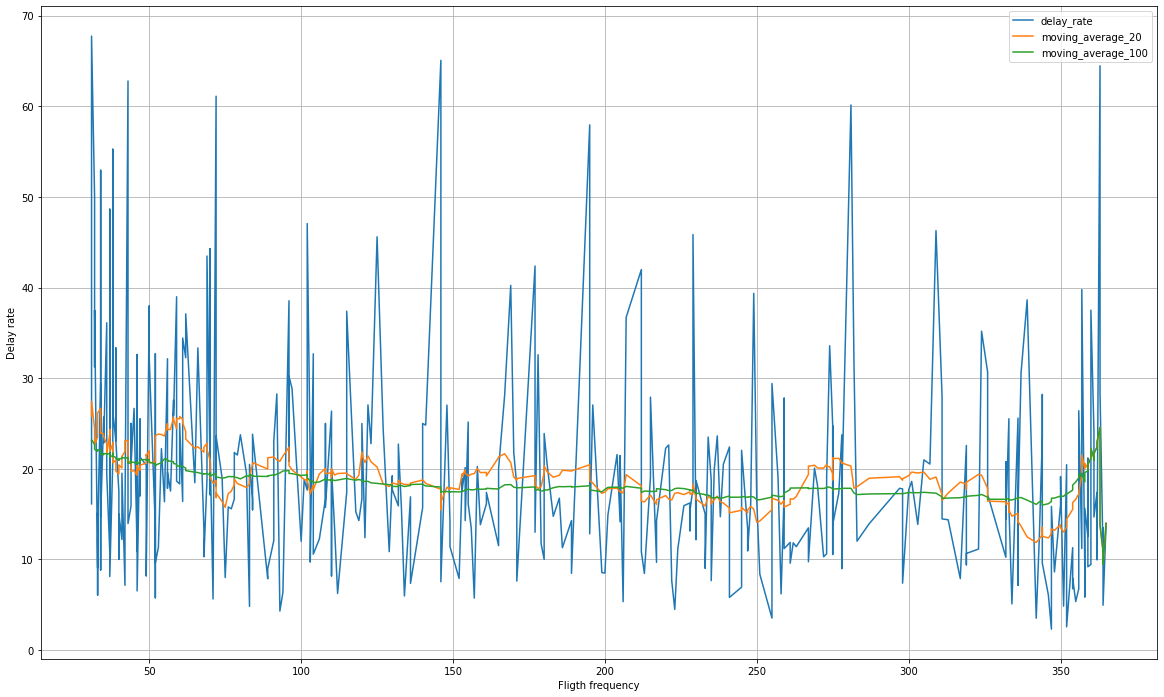

In [201]:
aux_df['moving_average_20'] = aux_df['delay_rate'].rolling(20, min_periods=1).mean()
aux_df['moving_average_100'] = aux_df['delay_rate'].rolling(100, min_periods=1).mean()

plt.figure(figsize=(20,12))
plt.plot(aux_df['flight_frequency'], aux_df['delay_rate'], label='delay_rate')
plt.plot(aux_df['flight_frequency'], aux_df['moving_average_20'], label='moving_average_20')
plt.plot(aux_df['flight_frequency'], aux_df['moving_average_100'], label='moving_average_100')
plt.grid()
plt.xlabel('Fligth frequency')
plt.ylabel('Delay rate')
plt.legend()
plt.show()

We see that this created feature `flight_frequency` does not explain delay rate, as it is very noisy, without a visible tendency and without tendency even in a moving average using 20 and 100 data points. So we can't even create buckets ("less than 100 flights", "between 100 and 300 flights", "more than 300 flights") and calculate the average delay rate in it because it should not bring valuable info to predict delay rate.

- inconsistency flag between flight scheduling and operation
    - airline

In [202]:
df['airline_inconsistency'] = df['airline_code_i'] != df['airline_code_o']
df['airline_inconsistency'].value_counts()

aux_df = pd.DataFrame(index=df['airline_inconsistency'].unique(), columns=['flight_frequency', 'delay_number', 'delay_rate'])
aux_df['flight_frequency'] = df[['airline_inconsistency', 'atraso_15']].groupby('airline_inconsistency').count()
aux_df['delay_number'] = df[['airline_inconsistency', 'atraso_15']].groupby('airline_inconsistency').sum()
aux_df['delay_rate'] =  100 * (aux_df['delay_number'] / aux_df['flight_frequency'])
aux_df = aux_df.sort_values(by='flight_frequency', ascending=False)
aux_df = aux_df.loc[aux_df['flight_frequency'] > 30, :]
aux_df

,flight_frequency,delay_number,delay_rate
False,49537,9253,18.678967
True,18668,3361,18.004071


So, airline inconsistency is not relevant to predict delay rate.

- periodo_dia

In [203]:
aux_df = pd.DataFrame(index=df['periodo_dia'].unique(), columns=['flight_frequency', 'delay_number', 'delay_rate'])
aux_df['flight_frequency'] = df[['periodo_dia', 'atraso_15']].groupby('periodo_dia').count()
aux_df['delay_number'] = df[['periodo_dia', 'atraso_15']].groupby('periodo_dia').sum()
aux_df['delay_rate'] =  100 * (aux_df['delay_number'] / aux_df['flight_frequency'])
aux_df = aux_df.sort_values(by='flight_frequency', ascending=False)
aux_df = aux_df.loc[aux_df['flight_frequency'] > 30, :]
aux_df

,flight_frequency,delay_number,delay_rate
tarde,25506,5086,19.940406
mañana,25351,4058,16.007258
noche,17348,3470,20.002306


Periodo_dia may be important to predict delay rate, so we will keep it as a model feature

### Which features should we expect to have a strong impact to predict delay? (Weight Of Evidence and Information Value)

After analysing all data and create some synthetic features, we ended up with the following features:

- Destination
- Airline
- month
- week_day
- flight_type
- temporada_alta
- periodo_dia

In [204]:
def categorical_woe_iv(df):

    # Padronização das cores dos gráficos
    darkred_patch = mpatches.Patch(color='darkred', label='WOE < -0,5')
    red_patch = mpatches.Patch(color='red', label='-0,5 < WOE < -0,15')
    light_red_patch = mpatches.Patch(color='lightcoral', label='-0,15 < WOE < 0')
    light_blue_patch = mpatches.Patch(color='cornflowerblue', label='0 < WOE < 0,15')
    blue_patch = mpatches.Patch(color='blue', label='0,15 < WOE < 0,5')
    navy_patch = mpatches.Patch(color='navy', label='WOE > 0,5')

    # Calculating Weight Of Evidence and Information Value

    variaveis = []
    information_value = []
    for var in df.select_dtypes('object'):

        legend_handles = []
        aux = []
        bins = np.sort(df[var].unique())
        columns = ['Bin', 'Count', '# Event (B)', '# Non-event (M)', '%Event', '%Non-event', 'WOE', 'Cor', '%Event - %Non-event', 'IV']
        for i in range(0, len(bins)):
            count = len(df[df[var] == bins[i]])
            event = len(df[(df[var] == bins[i]) & (df['target'] == 1)])
            non_event = len(df[(df[var] == bins[i]) & (df['target'] == 0)])
            event_per = event / len(df[df['target'] == 1])
            non_event_per = non_event / len(df[df['target'] == 0])
            woe = np.log(event_per / non_event_per)
            dif_per = event_per - non_event_per
            iv = dif_per * woe
            if woe > 0.5:
                cor = 'navy'
            elif woe > 0.15:
                cor = 'b'
            elif woe > 0:
                cor = 'cornflowerblue'
            elif woe > -0.15:
                cor = 'lightcoral'
            elif woe > -0.5:
                cor = 'r'
            else:
                cor = 'darkred'
            values = [bins[i], count, event, non_event, event_per, non_event_per, woe, cor, dif_per, iv]
            aux.append(dict(zip(columns, values)))
        woe_df = pd.DataFrame(aux)
        for color in woe_df['Cor'].unique():
            if color == 'navy':
                legend_handles.append(navy_patch)
            elif color == 'b':
                legend_handles.append(blue_patch)
            elif color == 'cornflowerblue':
                legend_handles.append(light_blue_patch)
            elif color == 'lightcoral':
                legend_handles.append(light_red_patch)
            elif color == 'r':
                legend_handles.append(red_patch)
            else:
                legend_handles.append(darkred_patch)

        # Plot dos WOE para cada bin
        x = [i for i in range(0, len(bins))]
        fig = plt.figure(figsize=(7, 5))
        plt.bar(woe_df['Bin'], height=woe_df['WOE'], color=np.array(woe_df['Cor']))
        plt.ylabel('WOE')
        plt.xlabel('Bin')
        plt.title(var)
        plt.legend(handles=legend_handles)
        plt.xticks(x, woe_df['Bin'])
        plt.margins(0.05)
        plt.tight_layout()
        plt.savefig(var)
        # plt.close()

        variaveis.append(var)
        information_value.append(woe_df['IV'].sum())

    iv = pd.DataFrame(information_value, index=variaveis, columns=['IV']).sort_values(by='IV')

    return iv

Usar LightGBM ou CatBoost pra poder contar com as variáveis categóricas sem muitos problemas

Usar algum outro método, mas sem as variáveis categóricas, pra poder melhorar o resultado do modelo eventualmente